# Trực Quan Hóa Dữ Liệu

Notebook này trực quan hóa các phân phối chính và mối quan hệ giữa các biến.


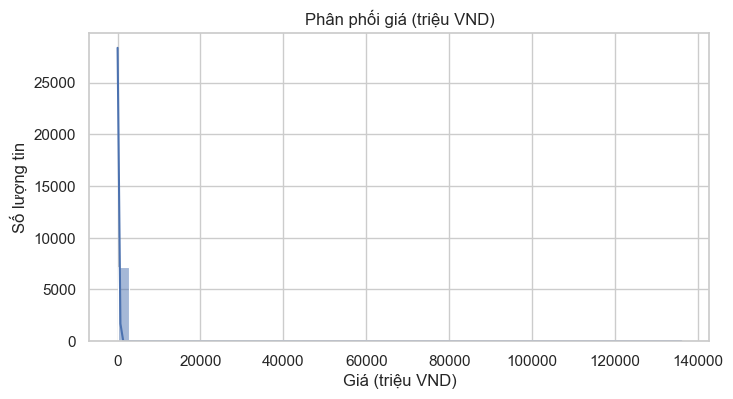

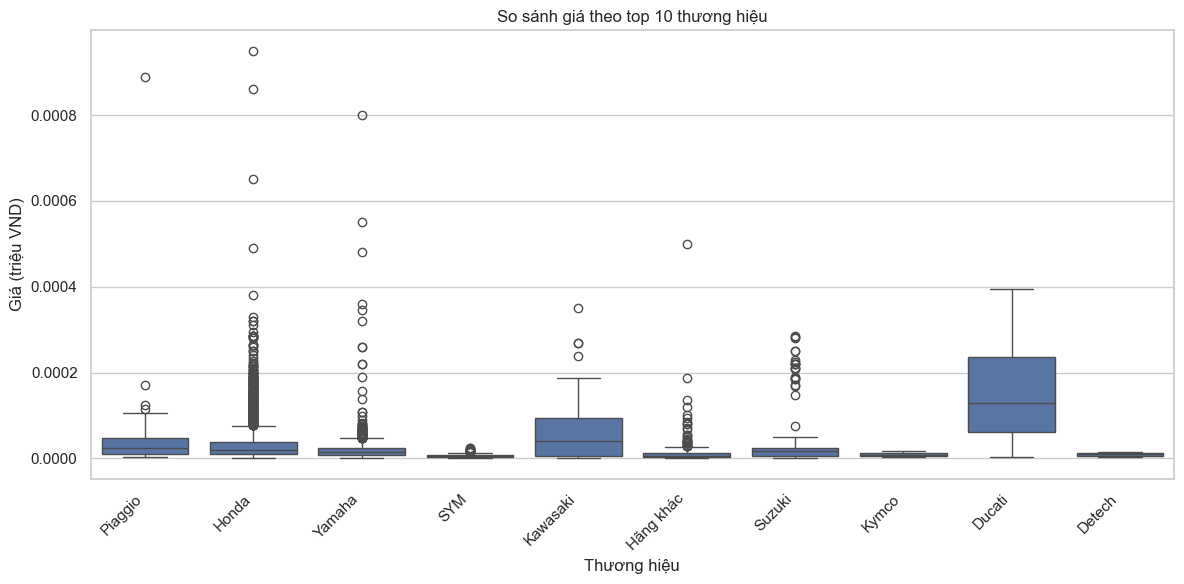

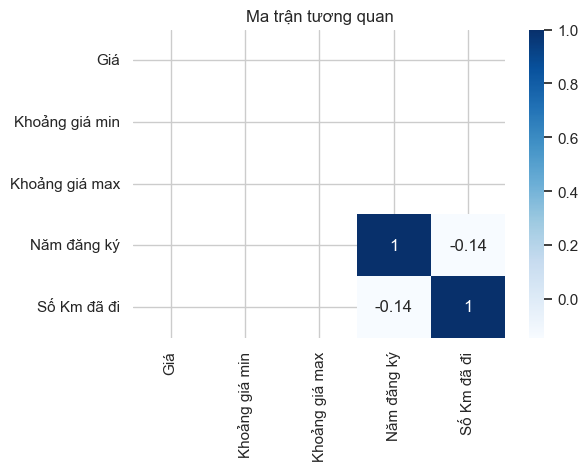

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme(style="whitegrid")

DATA_PATH = "/Users/doananh/Documents/Documents - Doan’s MacBook Pro/đồ án DS/project2/data_motobikes.xlsx - Sheet1.csv"

df = pd.read_csv(DATA_PATH)

# Phân phối giá
plt.figure(figsize=(8, 4))
price_series = (
    df["Giá"].astype(str)
    .str.replace("đ", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.replace(",", "", regex=False)
)
price_series = pd.to_numeric(price_series, errors="coerce") / 1_000_000
sns.histplot(price_series, bins=50, kde=True)
plt.title("Phân phối giá (triệu VND)")
plt.xlabel("Giá (triệu VND)")
plt.ylabel("Số lượng tin")
plt.show()

# Boxplot so sánh theo thương hiệu
import re

def parse_price(value):
    if pd.isna(value):
        return None
    value = str(value).lower()
    if value in {"đang cập nhật", "liên hệ", "thỏa thuận"}:
        return None
    value = value.replace("triệu", "tr").replace("tỷ", "ty")
    value = value.replace("đ", "").replace("vnđ", "").replace("vnd", "")
    value = value.replace(" ", "")
    match = re.search(r"([0-9]+(?:[\.,][0-9]+)?)", value)
    if not match:
        return None
    number = match.group(1).replace(",", ".")
    try:
        number = float(number)
    except ValueError:
        return None
    if "ty" in value or value.endswith("ty"):
        return number * 1000.0
    if "tr" in value or value.endswith("tr"):
        return number
    return number / 1_000_000

df["price_m"] = df["Giá"].apply(parse_price)

plt.figure(figsize=(12, 6))
top_brands = df["Thương hiệu"].value_counts().head(10).index.tolist()
df_top = df[df["Thương hiệu"].isin(top_brands) & df["price_m"].notna()].copy()
sns.boxplot(data=df_top, x="Thương hiệu", y="price_m")
plt.xticks(rotation=45, ha="right")
plt.title("So sánh giá theo top 10 thương hiệu")
plt.ylabel("Giá (triệu VND)")
plt.xlabel("Thương hiệu")
plt.tight_layout()
plt.show()

# Heatmap tương quan giữa các biến số
numeric_cols = ["Giá", "Khoảng giá min", "Khoảng giá max", "Năm đăng ký", "Số Km đã đi"]
num_df = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
plt.figure(figsize=(6, 4))
sns.heatmap(num_df.corr(), annot=True, cmap="Blues")
plt.title("Ma trận tương quan")
plt.show()

# Parse năm đăng ký
df["year"] = pd.to_numeric(df["Năm đăng ký"], errors="coerce")

# Plotly: scatter giá theo năm
df_plot = df[["year", "price_m"]].dropna()
fig = px.scatter(
    df_plot,
    x="year",
    y="price_m",
    title="Quan hệ Giá - Năm đăng ký",
    labels={"price_m": "Giá (triệu VND)", "year": "Năm đăng ký"},
    trendline="ols",
    trendline_color_override="red"
)
fig.update_layout(
    xaxis_title="Năm đăng ký",
    yaxis_title="Giá (triệu VND)",
    width=900,
    height=600
)
fig.show()
